---
format : html
echo : False
---

# Analyse PDM

**Présentation des résultats de l'examen du MELS pour la PDM.**



**Introduction**

Analyse des résultats des différentes épreuves en math CST secondaire 4 de la PDM de l'année à la lumière des résultats de l'examen du MELS.

Objectif : Réguler les différentes évaluations de l'année.

Notes sur les données : Seul les élèves ayant fait l'examen du MELS ont été retenus dans les analyses.

In [27]:
import pandas as pd

# Try two possible file paths for the data
try:
    file_path = '/content/drive/MyDrive/Travail/AnalyseSec4PDM/data_sansnoms.csv'
    df = pd.read_csv(file_path, encoding='cp1252', sep=';')
except (FileNotFoundError, OSError):
    file_path = 'data_sansnoms.csv'
    df = pd.read_csv(file_path, encoding='cp1252', sep=';')

# ...existing code for df_scores and cleaning...
df_scores = df[['Groupe', 'C2 Final École', 'C2 Final Modérée', 'Examen MELS']].copy()

# Identify and replace non-numeric values with NaN
df_scores['C2 Final École'] = df_scores['C2 Final École'].replace(['#VALEUR!', 'NE'], pd.NA)
df_scores['C2 Final Modérée'] = df_scores['C2 Final Modérée'].replace(['#VALEUR!', 'NE'], pd.NA)
df_scores['Examen MELS'] = df_scores['Examen MELS'].replace(['#VALEUR!', 'NE'], pd.NA)

# Convert columns to numeric, coercing errors to NaN
df_scores['C2 Final École'] = pd.to_numeric(df_scores['C2 Final École'], errors='coerce')
df_scores['C2 Final Modérée'] = pd.to_numeric(df_scores['C2 Final Modérée'], errors='coerce')
df_scores['Examen MELS'] = pd.to_numeric(df_scores['Examen MELS'], errors='coerce')

# Drop rows with NaN values in the score columns
df_scores.dropna(subset=['C2 Final École', 'C2 Final Modérée', 'Examen MELS'], inplace=True)

df_melted = df_scores.melt(id_vars=['Groupe'], var_name='Score Type', value_name='Score')


In [28]:
# Calcul des pourcentages de passage et de vulnérabilité
scores = df_scores['Examen MELS'].dropna()

# Pourcentage d'élèves ayant obtenu la note de passage (> 60)
pourcentage_passage = round((scores[scores > 60].count() / scores.count()),4) * 100 if scores.count() > 0 else 0

# Pourcentage d'élèves hors de la zone de vulnérabilité (> 75)
pourcentage_vulnerabilite = round((scores[scores > 75].count() / scores.count()),4) * 100 if scores.count() > 0 else 0


In [29]:
# Distribution des résultats de l'examen du MELS par groupe

from IPython.display import display, Markdown

# Create and display the dynamic Markdown
display(Markdown(f"{pourcentage_vulnerabilite}% des élèves se situent hors de la zone de vulnérabilité."))
display(Markdown(f"{pourcentage_passage}% des élèves se ont obtenus la note de passage."))


74.67% des élèves se situent hors de la zone de vulnérabilité.

94.67% des élèves se ont obtenus la note de passage.

In [30]:
# Histogramme des résultats de l'examn du MELS

import plotly.graph_objects as go
import plotly.figure_factory as ff
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import plotly # Import the top-level plotly module


# Ensure 'Score' and 'Groupe' are valid and drop NaNs
df_melted_filtered = df_melted.dropna(subset=['Score', 'Groupe']).copy()

# Filter to include only 'Examen MELS' scores
df_melted_filtered = df_melted_filtered[df_melted_filtered['Score Type'] == 'Examen MELS'].copy()


# Create traces for each group's histogram and density curve, and the overall histogram and density curve
traces = []

# Define bin settings
bin_settings = dict(start=0, end=100, size=5) # Bins from 0 to 100 with size 5 (20 bins)

# Add overall histogram trace
overall_hist = go.Histogram(x=df_melted_filtered['Score'],
                           xbins=bin_settings,
                           name='All Groups (Histogram)',
                           marker_color='gray',
                           opacity=1.0, # Full opacity for selected view
                           marker_line=dict(width=1, color='black'),
                           visible=True) # Visible by default
traces.append(overall_hist)


# Add histogram traces for each group
colors = plotly.colors.qualitative.Plotly # Use a color sequence
groups = sorted(df_melted_filtered['Groupe'].unique()) # Sort groups alphabetically
for i, group in enumerate(groups):
    group_data = df_melted_filtered[df_melted_filtered['Groupe'] == group]
    color = colors[i % len(colors)]

    # Add histogram trace for the group
    traces.append(go.Histogram(x=group_data['Score'],
                               xbins=bin_settings,
                               name=f'Groupe {group} (Histogram)',
                               marker_color=color,
                               opacity=1.0, # Full opacity for selected view
                               marker_line=dict(width=1, color='black'),
                               visible=False)) # Hidden by default

# Add vertical line trace (initially at 60)
initial_line_x = 60

# Create the figure
fig = go.Figure(data=traces)
all_group = True # Set all_group to True to display dropdown menu
# Create buttons for updatemenus
buttons = [
    dict(label='All Groups',
         method='update',
         # Find the indices of the 'All Groups' histogram and density traces
         args=[{'visible': [t.name == 'All Groups (Histogram)' for t in traces]}, # Show All Groups histogram, hide others
               {'title': 'Distribution des Scores (Tous Groupes)'}]) # Update title
]

# Add buttons for each group if all_group is True
if all_group:
    # Need to ensure the order of visibility corresponds to the sorted groups
    group_names = sorted(df_melted_filtered['Groupe'].unique()) # Get sorted group names again for indexing
    for i, group in enumerate(group_names):
        group_traces_visibility = [False] * len(traces) # Start with all hidden

        # Find the index of the current group's histogram trace
        hist_trace_index = traces.index(next(t for t in traces if t.name == f'Groupe {group} (Histogram)'))
        group_traces_visibility[hist_trace_index] = True # Set the current group's histogram trace to visible

        buttons.append(dict(label=f'Groupe {group}',
                            method='update',
                            args=[{'visible': group_traces_visibility},
                                  {'title': f'Distribution des résultat de l\'examen du MELS (Groupe {group})'}])) # Update title

# Calculate initial percentages and counts
total_scores = len(df_melted_filtered)
scores_less_than_initial = df_melted_filtered[df_melted_filtered['Score'] < initial_line_x].shape[0]
scores_greater_than_initial = df_melted_filtered[df_melted_filtered['Score'] >= initial_line_x].shape[0]
percentage_less_than_initial = (scores_less_than_initial / total_scores) * 100 if total_scores > 0 else 0
percentage_greater_than_initial = (scores_greater_than_initial / total_scores) * 100 if total_scores > 0 else 0


# Add annotations for percentages and counts
annotations = [
    dict(
        text=f'{percentage_less_than_initial:.2f}% ({scores_less_than_initial}) < {initial_line_x}',
        x=initial_line_x, # Set x position to the threshold value
        y=1.05, # Adjust y position relative to the top of the plot
        xref='x', # Use x-axis as reference
        yref='paper', # Use paper as reference for y (relative to the plot)
        showarrow=False,
        font=dict(color="blue", size=12),
        xanchor='right' # Anchor to the right of the text
    ),
    dict(
        text=f'{percentage_greater_than_initial:.2f}% ({scores_greater_than_initial}) >= {initial_line_x}',
        x=initial_line_x, # Set x position to the threshold value
        y=1.05, # Adjust y position relative to the top of the plot
        xref='x', # Use x-axis as reference
        yref='paper', # Use paper as reference for y (relative to the plot)
        showarrow=False,
        font=dict(color="blue", size=12),
        xanchor='left' # Anchor to the left of the text
    )
]


# Add a slider to the layout
steps = []
for i in range(0, 101): # Slider from 0 to 100

    # Calculate percentages and counts for the current threshold
    scores_less_than = df_melted_filtered[df_melted_filtered['Score'] < i].shape[0]
    scores_greater_than = df_melted_filtered[df_melted_filtered['Score'] >= i].shape[0]
    percentage_less_than = (scores_less_than / total_scores) * 100 if total_scores > 0 else 0
    percentage_greater_than = (scores_greater_than / total_scores) * 100 if total_scores > 0 else 0


    step = dict(
        method='relayout',
        args=[{
            'shapes': [{'x0': i, 'x1': i, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper'}], # Update vertical line position
            'annotations': [ # Update annotations
                dict(
                    text=f'{percentage_less_than:.2f}% ({scores_less_than}) < {i}',
                    x=i, # Set x position to the threshold value
                    y=1.05, # Adjust y position relative to the top of the plot
                    xref='x', # Use x-axis as reference
                    yref='paper', # Use paper as reference for y (relative to the plot)
                    showarrow=False,
                    font=dict(color="blue", size=12),
                    xanchor='right'
                ),
                dict(
                    text=f'{percentage_greater_than:.2f}% ({scores_greater_than}) >= {i}',
                    x=i, # Set x position to the threshold value
                    y=1.05, # Adjust y position relative to the top of the plot
                    xref='x', # Use x-axis as reference
                    yref='paper', # Use paper as reference for y (relative to the plot)
                    showarrow=False,
                    font=dict(color="blue", size=12),
                    xanchor='left'
                )
            ]
        }],
        label=str(i)
    )
    steps.append(step)

sliders = [dict(
    active=60, # Initial position at 60
    steps=steps,
    pad={"t": 50}, # Add padding at the top
    currentvalue={"prefix": "Threshold: "} # Add a prefix to the current value display
)]

# Create updatemenu based on all_group
updatemenus = []
if all_group:
    updatemenus=[
        dict(
            type='dropdown',
            direction='down',
            x=1.0, # Set x to 1 for right alignment
            y=1.15, # Keep y slightly above the plot for the dropdown
            xanchor='right', # Anchor the dropdown to the right
            yanchor='top', # Anchor the dropdown to the top
            showactive=True,
            buttons=buttons
        )
    ]


# Update layout with updatemenus, slider, and initial annotations
fig.update_layout(
    updatemenus=updatemenus,
    sliders=sliders,
    title_text='Distribution des Scores (Tous Groupes)', # Initial title
    xaxis_title='Score',
    yaxis_title='Nombre d\'occurrences', # Changed y-axis title to Number of occurrences
    xaxis=dict(range=[0, 100], tickmode='linear', tick0=0, dtick=10),
    # Remove fixed y-axis range to allow Plotly to autoscale
    # yaxis=dict(range=[0, max_density_estimate * 1.2]), # Removed
    template='plotly_white',
    font=dict(family="sans-serif", size=12, color="#000"),
    annotations=annotations # Add initial annotations to the layout
    )

# Add initial vertical line shape
fig.add_shape(type="line",
              x0=initial_line_x, y0=0, x1=initial_line_x, y1=1,
              xref='x', yref='paper',
              line=dict(color="blue", width=2, dash="dash"))


# Show the interactive plot
fig.show() # Removed renderer="colab"

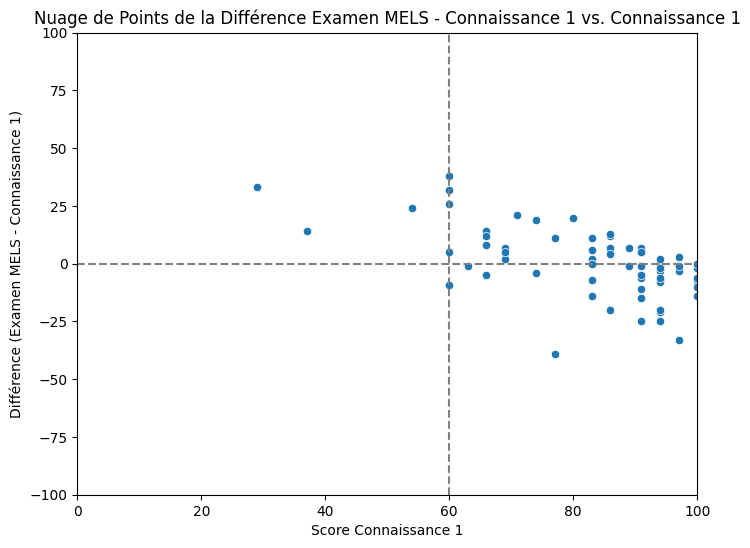

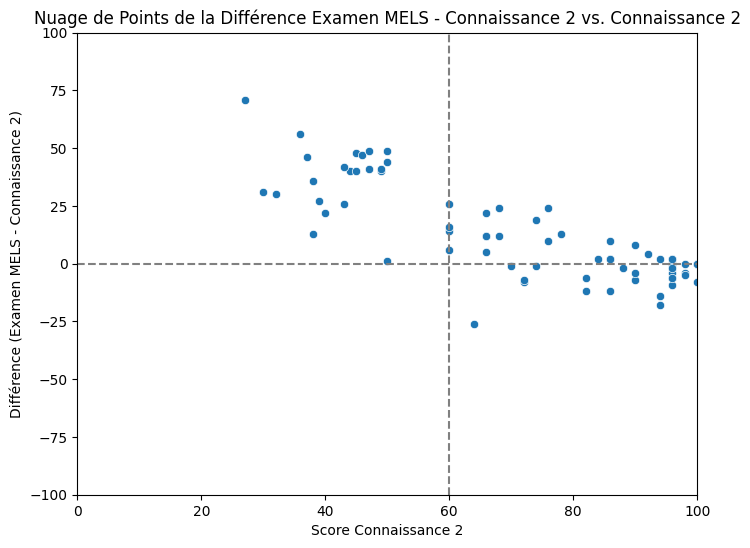

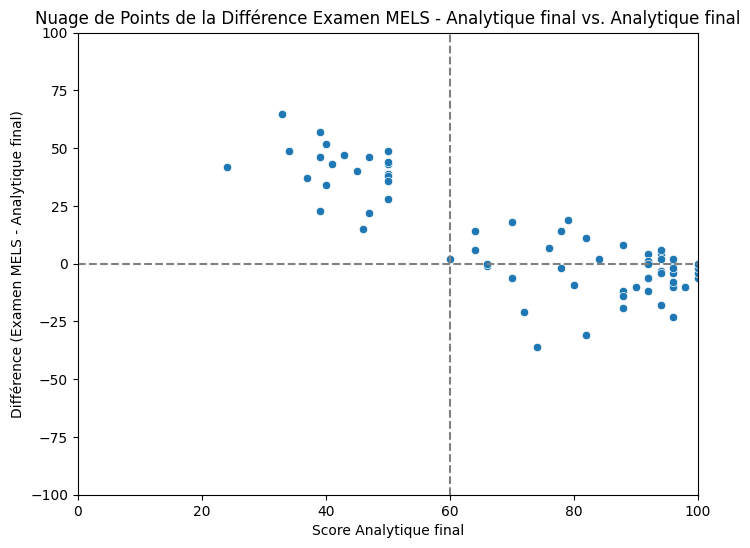

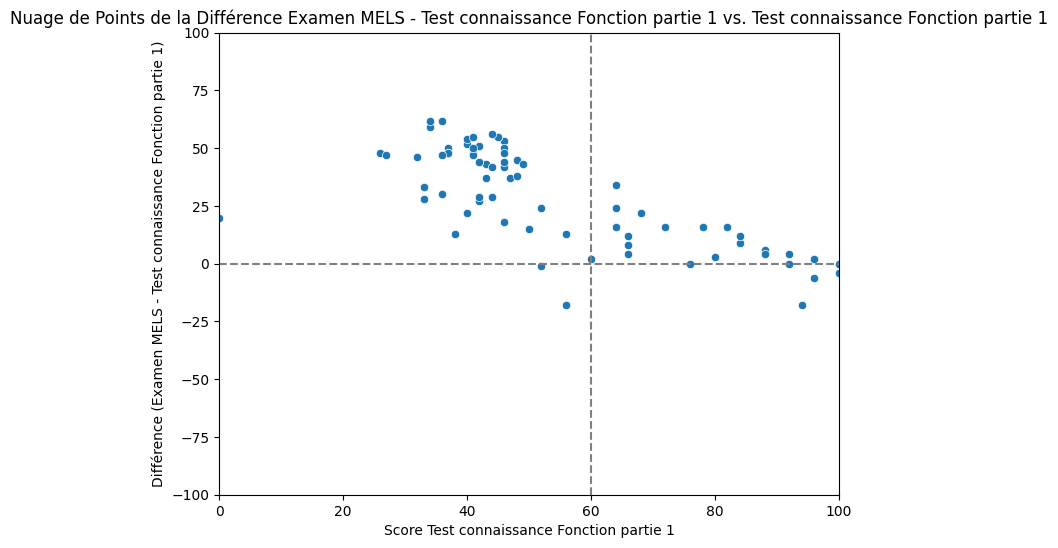

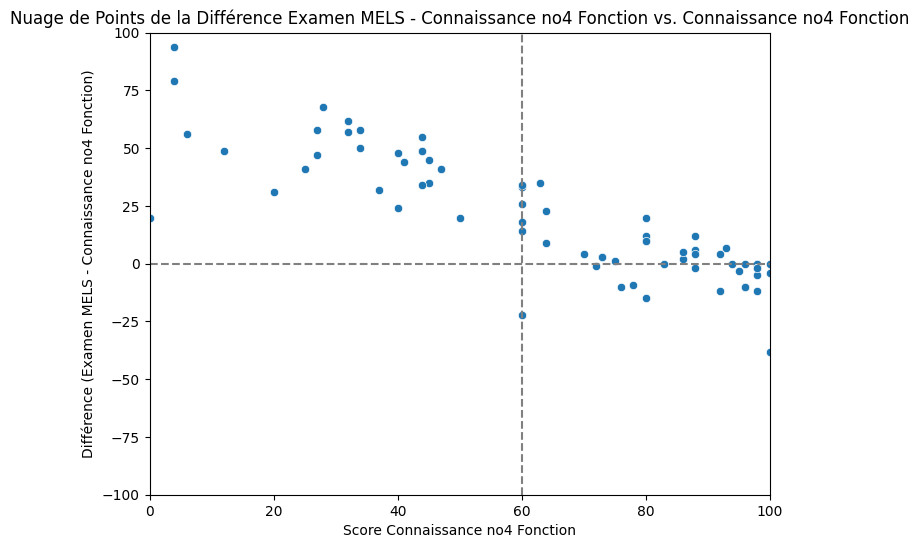

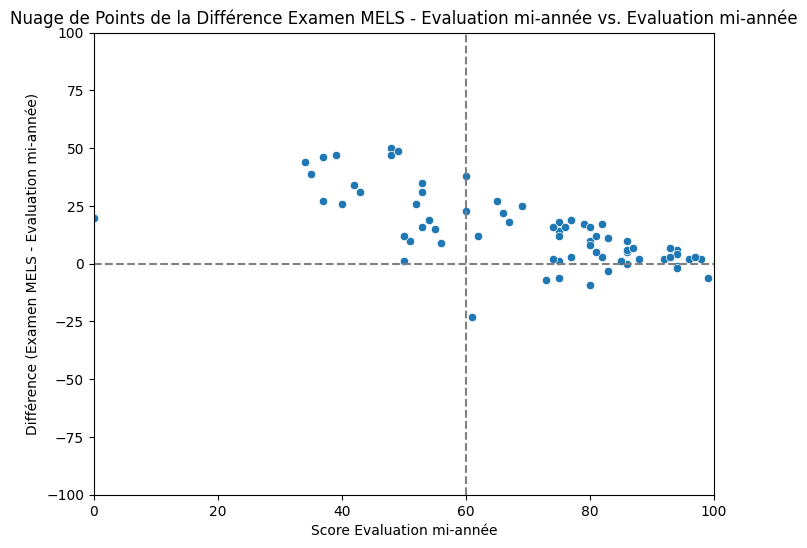

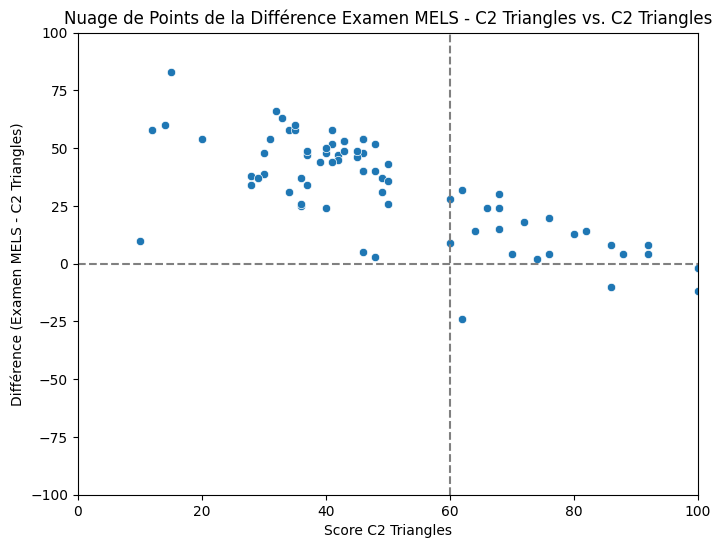

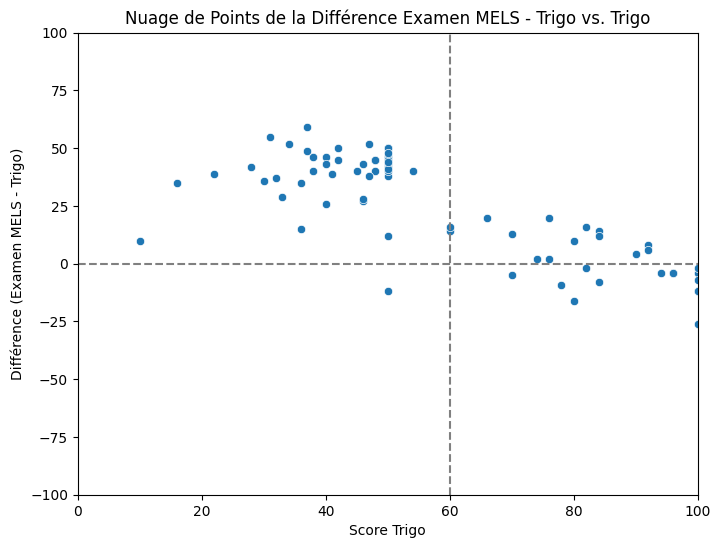

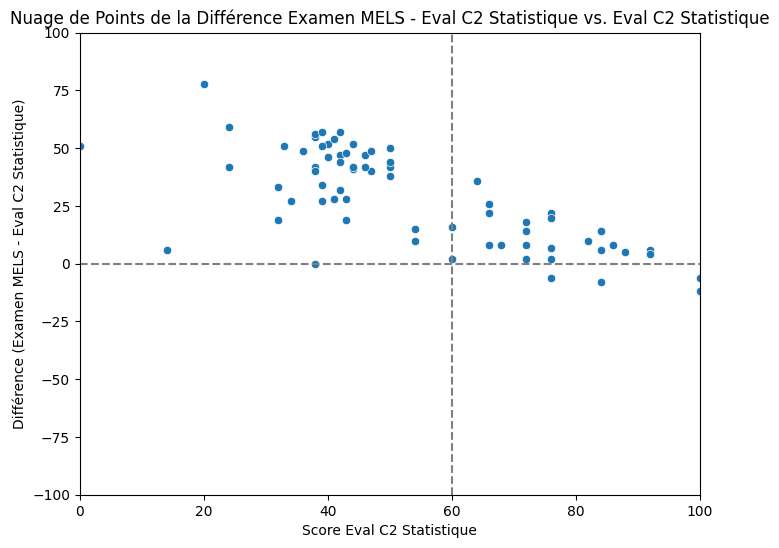

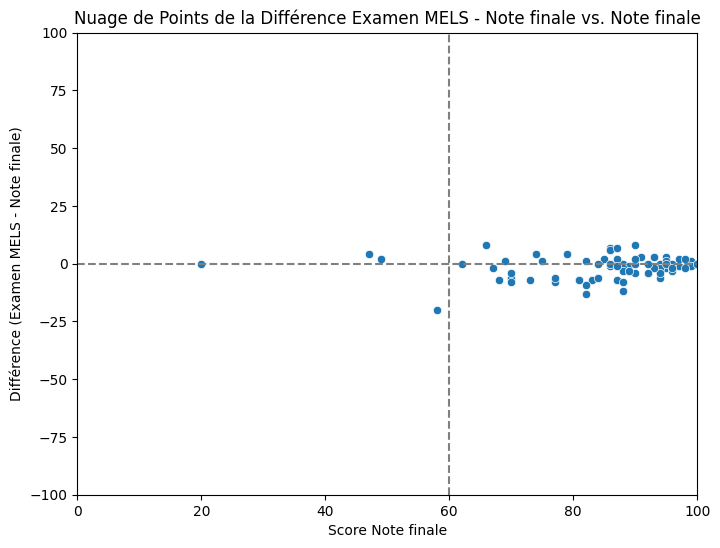

In [5]:
# @title Default title text
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Recreate df_selected_columns and calculate the correlation matrix
columns_to_keep = [col for col in df.columns if 'C1' not in col and col != 'Groupe' and col != 'Fiche']
df_selected_columns = df[columns_to_keep].copy()

for col in df_selected_columns.columns:
    df_selected_columns[col] = pd.to_numeric(df_selected_columns[col], errors='coerce')

correlation_matrix = df_selected_columns.corr()

# Identify the columns from the second correlation matrix
columns_from_corr_matrix = correlation_matrix.columns.tolist()

# Identify columns to exclude
excluded_columns = ['C2 Final École', 'C2 Final Modérée', 'Modération', 'C2 Final Bulletin']

# Create a list of feature column names based on the exclusion criteria, keeping only those from the second correlation matrix
feature_columns_for_scatter = [col for col in columns_from_corr_matrix if col not in excluded_columns and col != 'Examen MELS']

# Create a scatter plot for the difference between Examen MELS and each feature vs. the feature
for col in feature_columns_for_scatter:
    plt.figure(figsize=(8, 6))

    # Select the relevant columns for the current plot and drop rows with NaN
    temp_df = df[[col, 'Examen MELS']].copy()
    for temp_col in temp_df.columns:
        temp_df[temp_col] = pd.to_numeric(temp_df[temp_col], errors='coerce')
    temp_df.dropna(inplace=True)

    # Calculate the difference
    if not temp_df.empty:
        temp_df['Difference'] = temp_df['Examen MELS'] - temp_df[col]

        sns.scatterplot(data=temp_df, x=col, y='Difference')
        plt.title(f'Nuage de Points de la Différence Examen MELS - {col} vs. {col}') # Translated title
        plt.xlabel(f'Score {col}') # Translated x-label
        plt.ylabel(f'Différence (Examen MELS - {col})') # Translated y-label

        # Set x and y axis limits
        plt.xlim(0, 100)
        plt.ylim(-100, 100) # Adjust y-limit as differences can be negative

        # Add horizontal line at y=0
        plt.axhline(0, color='gray', linestyle='--')

        # Add vertical line at x=60
        plt.axvline(60, color='gray', linestyle='--')


        plt.show()

In [6]:
for col in feature_columns_for_scatter:
    # Select the relevant columns and handle non-numeric values
    temp_df = df[[col, 'Examen MELS']].copy()
    for temp_col in temp_df.columns:
        temp_df[temp_col] = pd.to_numeric(temp_df[temp_col], errors='coerce')
    temp_df.dropna(inplace=True)

    # Filter data points around (20, 90) - adjust tolerance as needed
    # Assuming 'around (20, 90)' means within a certain range of x=20 and y=90
    x_tolerance = 10  # Adjust the tolerance for the x-axis (feature score)
    y_tolerance = 10  # Adjust the tolerance for the y-axis (Examen MELS score)

    filtered_df = temp_df[
        (temp_df[col] >= 20 - x_tolerance) & (temp_df[col] <= 20 + x_tolerance) &
        (temp_df['Examen MELS'] >= 90 - y_tolerance) & (temp_df['Examen MELS'] <= 90 + y_tolerance)
    ].copy()


    if not filtered_df.empty:
        # Calculate the difference between 'Examen MELS' and the feature score
        filtered_df['Difference'] = filtered_df['Examen MELS'] - filtered_df[col]

        # Calculate the mean difference
        mean_diff = filtered_df['Difference'].mean()

        print(f"Mean difference for {col} vs. Examen MELS around (20, 90): {mean_diff:.2f}")
    else:
        print(f"No data points found for {col} vs. Examen MELS around (20, 90) with the current tolerance.")

No data points found for Connaissance 1 vs. Examen MELS around (20, 90) with the current tolerance.
Mean difference for Connaissance 2 vs. Examen MELS around (20, 90): 71.00
No data points found for Analytique final vs. Examen MELS around (20, 90) with the current tolerance.
No data points found for Test connaissance Fonction partie 1 vs. Examen MELS around (20, 90) with the current tolerance.
Mean difference for Connaissance no4 Fonction vs. Examen MELS around (20, 90): 63.00
No data points found for Evaluation mi-année vs. Examen MELS around (20, 90) with the current tolerance.
Mean difference for C2 Triangles vs. Examen MELS around (20, 90): 83.00
No data points found for Trigo vs. Examen MELS around (20, 90) with the current tolerance.
Mean difference for Eval C2 Statistique vs. Examen MELS around (20, 90): 68.50
No data points found for Note finale vs. Examen MELS around (20, 90) with the current tolerance.


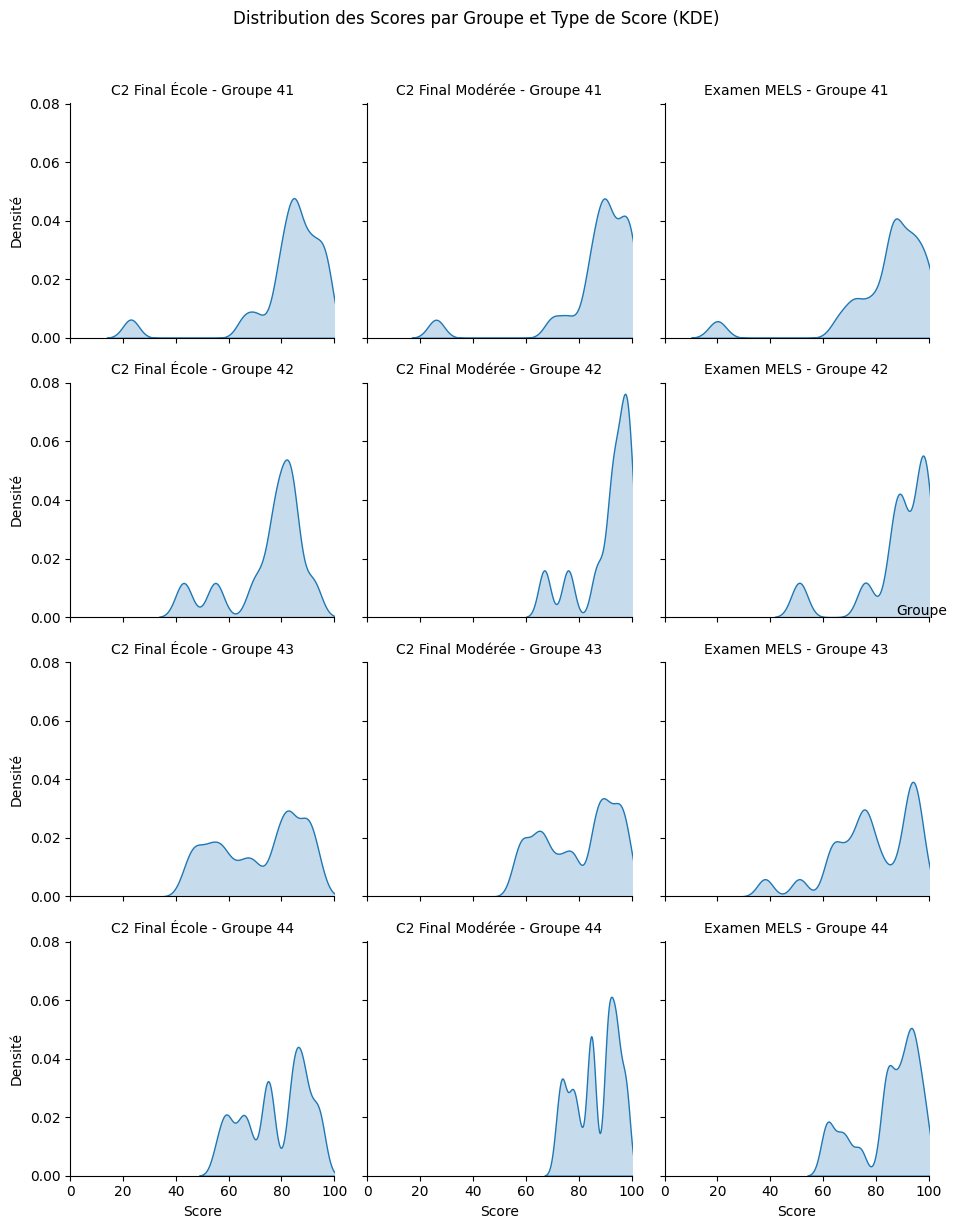

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

g = sns.FacetGrid(df_melted, row='Groupe', col='Score Type', height=3)
g.map(sns.kdeplot, 'Score', fill=True, bw_adjust=0.35)
g.add_legend(title='Groupe')
g.fig.suptitle('Distribution des Scores par Groupe et Type de Score (KDE)', y=1.02) # Translated title
g.set_axis_labels("Score", "Densité") # Translated axis labels
g.set(xlim=(0, 100)) # Set x-axis limits to 0 and 100
g.set_titles(template='{col_name} - Groupe {row_name}') # Set subplot titles

# Add x-axis ticks and labels
for ax in g.axes.flat:
    ax.set_xticks(np.arange(0, 101, 20)) # Set ticks every 20 units from 0 to 100
    ax.set_xticklabels(np.arange(0, 101, 20)) # Set labels for the ticks

plt.tight_layout()
plt.show()

In [8]:
df_numeric = df.drop('Groupe', axis=1)
display(df_numeric.head())

,Fiche,Connaissance 1,Connaissance 2,Analytique final,Point de rencontre C1,Premier projet C1,Test connaissance Fonction partie 1,Connaissance no4 Fonction,Evaluation mi-année,C1 Mozaique,...,C2 Triangles,Trigo,Eval C2 Statistique,C1 Final bulletin,C2 Final École,C2 Final Modérée,Examen MELS,Modération,C2 Final Bulletin,Note finale
0,6059042,91,96,96,NE,94,100,100,79,100,...,76,100,92,99.0,89.0,95.0,96,6.0,96,97
1,6031074,91,96,96,NE,100,82,98,48,100,...,68,84,84,100.0,79.0,94.0,98,15.0,98,99
2,6083117,97,72,70,NE,89,46,40,37,60,...,40,80,54,79.0,57.0,67.0,64,10.0,66,70
3,6051742,91,94,92,96,96,43,92,77,92,...,49,41,38,92.0,85.0,90.0,80,5.0,85,87
4,6083125,86,90,79,NE,60,64,63,60,80,...,32,100,76,87.0,70.0,87.0,98,17.0,98,95


In [9]:
for col in df_numeric.columns:
    df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')

display(df_numeric.head())

,Fiche,Connaissance 1,Connaissance 2,Analytique final,Point de rencontre C1,Premier projet C1,Test connaissance Fonction partie 1,Connaissance no4 Fonction,Evaluation mi-année,C1 Mozaique,...,C2 Triangles,Trigo,Eval C2 Statistique,C1 Final bulletin,C2 Final École,C2 Final Modérée,Examen MELS,Modération,C2 Final Bulletin,Note finale
0,6059042,91.0,96.0,96.0,NaN,94.0,100.0,100.0,79.0,100.0,...,76.0,100.0,92.0,99.0,89.0,95.0,96.0,6.0,96.0,97.0
1,6031074,91.0,96.0,96.0,NaN,100.0,82.0,98.0,48.0,100.0,...,68.0,84.0,84.0,100.0,79.0,94.0,98.0,15.0,98.0,99.0
2,6083117,97.0,72.0,70.0,NaN,89.0,46.0,40.0,37.0,60.0,...,40.0,80.0,54.0,79.0,57.0,67.0,64.0,10.0,66.0,70.0
3,6051742,91.0,94.0,92.0,96.0,96.0,43.0,92.0,77.0,92.0,...,49.0,41.0,38.0,92.0,85.0,90.0,80.0,5.0,85.0,87.0
4,6083125,86.0,90.0,79.0,NaN,60.0,64.0,63.0,60.0,80.0,...,32.0,100.0,76.0,87.0,70.0,87.0,98.0,17.0,98.0,95.0


## Calculate correlation

### Subtask:
Calculate the correlation matrix for the selected numeric columns.


**Reasoning**:
Calculate the correlation matrix for the selected numeric columns.



In [10]:
correlation_matrix = df_numeric.corr()
display(correlation_matrix)

,Fiche,Connaissance 1,Connaissance 2,Analytique final,Point de rencontre C1,Premier projet C1,Test connaissance Fonction partie 1,Connaissance no4 Fonction,Evaluation mi-année,C1 Mozaique,...,C2 Triangles,Trigo,Eval C2 Statistique,C1 Final bulletin,C2 Final École,C2 Final Modérée,Examen MELS,Modération,C2 Final Bulletin,Note finale
Fiche,1.000000,-0.030334,-0.175543,-0.182679,-0.381837,-0.260756,-0.091146,-0.369978,-0.334452,-0.327413,...,-0.180590,-0.127239,-0.249505,-0.274044,-0.279424,-0.252194,-0.144584,0.189967,-0.168232,-0.282386
Connaissance 1,-0.030334,1.000000,0.657766,0.553842,0.199369,0.401696,0.293006,0.360323,0.547417,0.589285,...,0.345410,0.304361,0.321674,0.710058,0.801596,0.800863,0.532279,-0.356944,0.600231,0.686549
Connaissance 2,-0.175543,0.657766,1.000000,0.882810,0.113856,0.245718,0.625325,0.823178,0.495038,0.346475,...,0.609010,0.581727,0.602313,0.490641,0.566634,0.560167,0.427271,-0.368203,0.446631,0.500739
Analytique final,-0.182679,0.553842,0.882810,1.000000,-0.085267,0.166931,0.529200,0.807238,0.436822,0.214142,...,0.582594,0.455251,0.445840,0.314676,0.565216,0.546372,0.277052,-0.296702,0.323498,0.360146
Point de rencontre C1,-0.381837,0.199369,0.113856,-0.085267,1.000000,0.824577,0.570037,0.310929,0.654281,0.658687,...,0.427274,0.551700,0.540924,0.874574,0.665658,0.750506,0.753672,0.168371,0.767553,0.809546
Premier projet C1,-0.260756,0.401696,0.245718,0.166931,0.824577,1.000000,0.273002,0.375335,0.576434,0.537429,...,0.331541,0.309093,0.296729,0.703748,0.725593,0.745356,0.591510,-0.192915,0.633058,0.664197
Test connaissance Fonction partie 1,-0.091146,0.293006,0.625325,0.529200,0.570037,0.273002,1.000000,0.542527,0.421229,0.263392,...,0.832990,0.789400,0.766473,0.415395,0.316856,0.421587,0.374971,0.209330,0.393301,0.390105
Connaissance no4 Fonction,-0.369978,0.360323,0.823178,0.807238,0.310929,0.375335,0.542527,1.000000,0.531927,0.353083,...,0.549748,0.464122,0.456758,0.397693,0.502907,0.479137,0.403740,-0.279746,0.407935,0.374196
Evaluation mi-année,-0.334452,0.547417,0.495038,0.436822,0.654281,0.576434,0.421229,0.531927,1.000000,0.568528,...,0.497274,0.277346,0.304748,0.562597,0.804905,0.778871,0.654675,-0.357589,0.707273,0.562688
C1 Mozaique,-0.327413,0.589285,0.346475,0.214142,0.658687,0.537429,0.263392,0.353083,0.568528,1.000000,...,0.304023,0.301447,0.383858,0.844349,0.729293,0.742611,0.657158,-0.284820,0.682445,0.688424


**Reasoning**:
Create a heatmap of the correlation matrix to visualize the relationships between the numeric columns.



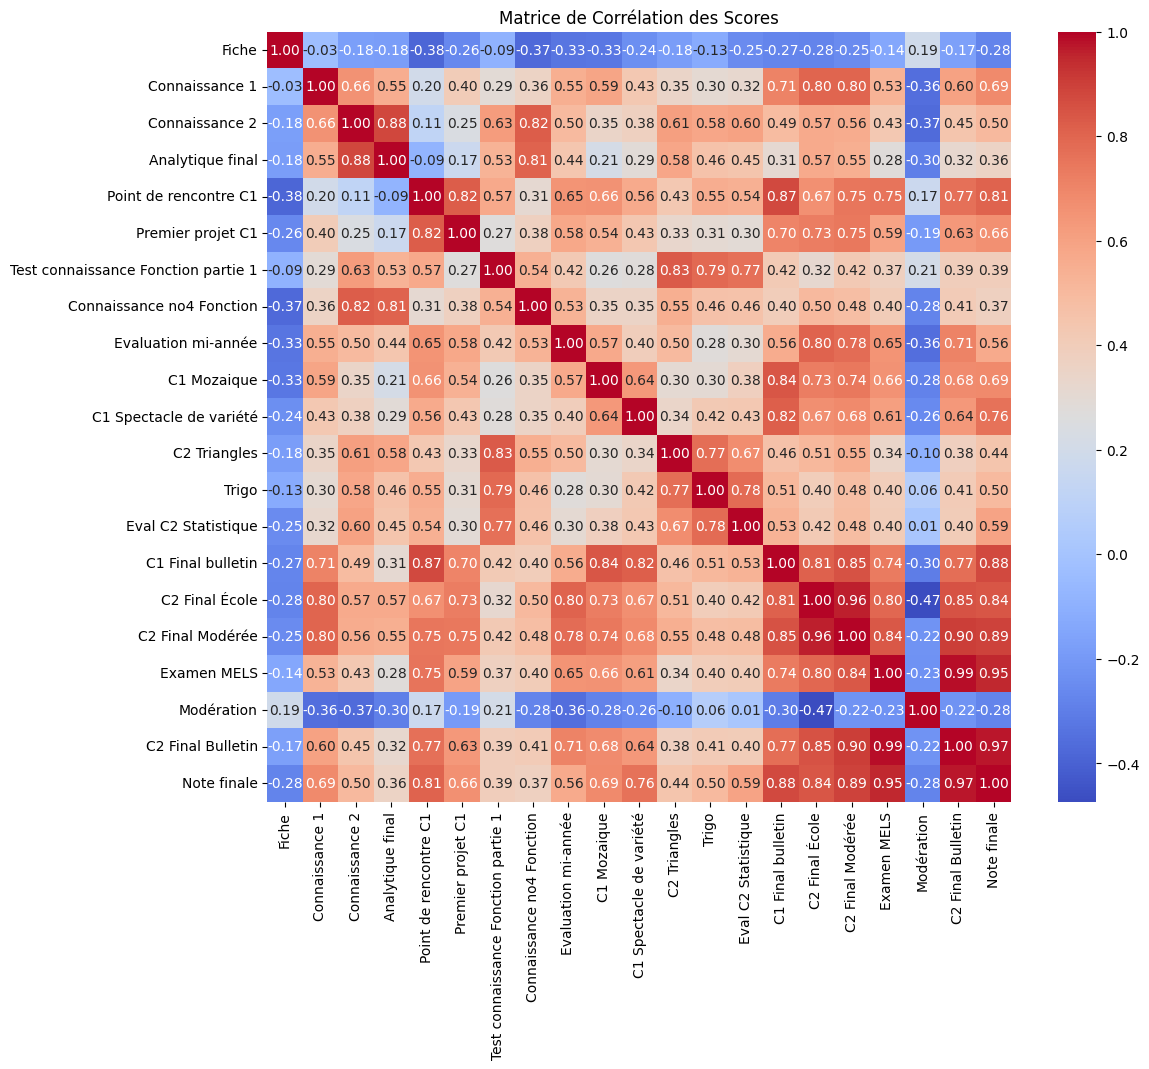

In [11]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de Corrélation des Scores') # Translated title
plt.show()

**Reasoning**:
Select columns that do not contain 'C1' and are not 'Groupe', then display the head of the new dataframe.



In [12]:
columns_to_keep = [col for col in df.columns if 'C1' not in col and col != 'Groupe' and col != 'Fiche']
df_selected_columns = df[columns_to_keep]
display(df_selected_columns.head())

,Connaissance 1,Connaissance 2,Analytique final,Test connaissance Fonction partie 1,Connaissance no4 Fonction,Evaluation mi-année,C2 Triangles,Trigo,Eval C2 Statistique,C2 Final École,C2 Final Modérée,Examen MELS,Modération,C2 Final Bulletin,Note finale
0,91,96,96,100,100,79,76,100,92,89.0,95.0,96,6.0,96,97
1,91,96,96,82,98,48,68,84,84,79.0,94.0,98,15.0,98,99
2,97,72,70,46,40,37,40,80,54,57.0,67.0,64,10.0,66,70
3,91,94,92,43,92,77,49,41,38,85.0,90.0,80,5.0,85,87
4,86,90,79,64,63,60,32,100,76,70.0,87.0,98,17.0,98,95


**Reasoning**:
Convert all columns in the selected DataFrame to numeric, coercing errors to NaN.



In [13]:
for col in df_selected_columns.columns:
    df_selected_columns[col] = pd.to_numeric(df_selected_columns[col], errors='coerce')

display(df_selected_columns.head())

,Connaissance 1,Connaissance 2,Analytique final,Test connaissance Fonction partie 1,Connaissance no4 Fonction,Evaluation mi-année,C2 Triangles,Trigo,Eval C2 Statistique,C2 Final École,C2 Final Modérée,Examen MELS,Modération,C2 Final Bulletin,Note finale
0,91.0,96.0,96.0,100.0,100.0,79.0,76.0,100.0,92.0,89.0,95.0,96.0,6.0,96.0,97.0
1,91.0,96.0,96.0,82.0,98.0,48.0,68.0,84.0,84.0,79.0,94.0,98.0,15.0,98.0,99.0
2,97.0,72.0,70.0,46.0,40.0,37.0,40.0,80.0,54.0,57.0,67.0,64.0,10.0,66.0,70.0
3,91.0,94.0,92.0,43.0,92.0,77.0,49.0,41.0,38.0,85.0,90.0,80.0,5.0,85.0,87.0
4,86.0,90.0,79.0,64.0,63.0,60.0,32.0,100.0,76.0,70.0,87.0,98.0,17.0,98.0,95.0


## Calculate correlation

### Subtask:
Calculate the correlation matrix for the selected numeric columns.


**Reasoning**:
Calculate the pairwise correlation of columns in df_selected_columns and store the result in a variable named correlation_matrix.



In [14]:
correlation_matrix = df_selected_columns.corr()
display(correlation_matrix)

,Connaissance 1,Connaissance 2,Analytique final,Test connaissance Fonction partie 1,Connaissance no4 Fonction,Evaluation mi-année,C2 Triangles,Trigo,Eval C2 Statistique,C2 Final École,C2 Final Modérée,Examen MELS,Modération,C2 Final Bulletin,Note finale
Connaissance 1,1.000000,0.657766,0.553842,0.293006,0.360323,0.547417,0.345410,0.304361,0.321674,0.801596,0.800863,0.532279,-0.356944,0.600231,0.686549
Connaissance 2,0.657766,1.000000,0.882810,0.625325,0.823178,0.495038,0.609010,0.581727,0.602313,0.566634,0.560167,0.427271,-0.368203,0.446631,0.500739
Analytique final,0.553842,0.882810,1.000000,0.529200,0.807238,0.436822,0.582594,0.455251,0.445840,0.565216,0.546372,0.277052,-0.296702,0.323498,0.360146
Test connaissance Fonction partie 1,0.293006,0.625325,0.529200,1.000000,0.542527,0.421229,0.832990,0.789400,0.766473,0.316856,0.421587,0.374971,0.209330,0.393301,0.390105
Connaissance no4 Fonction,0.360323,0.823178,0.807238,0.542527,1.000000,0.531927,0.549748,0.464122,0.456758,0.502907,0.479137,0.403740,-0.279746,0.407935,0.374196
Evaluation mi-année,0.547417,0.495038,0.436822,0.421229,0.531927,1.000000,0.497274,0.277346,0.304748,0.804905,0.778871,0.654675,-0.357589,0.707273,0.562688
C2 Triangles,0.345410,0.609010,0.582594,0.832990,0.549748,0.497274,1.000000,0.774619,0.673112,0.509724,0.550803,0.343395,-0.104472,0.383891,0.443366
Trigo,0.304361,0.581727,0.455251,0.789400,0.464122,0.277346,0.774619,1.000000,0.784025,0.398900,0.480028,0.399906,0.064083,0.412745,0.496854
Eval C2 Statistique,0.321674,0.602313,0.445840,0.766473,0.456758,0.304748,0.673112,0.784025,1.000000,0.416460,0.483594,0.404811,0.014605,0.403977,0.592093
C2 Final École,0.801596,0.566634,0.565216,0.316856,0.502907,0.804905,0.509724,0.398900,0.416460,1.000000,0.964494,0.797553,-0.473222,0.853786,0.842075


## Visualize correlation

### Subtask:
Create a heatmap to visualize the correlation matrix.


**Reasoning**:
Create a heatmap of the correlation matrix to visualize the relationships between the numeric columns, including annotations and a title.



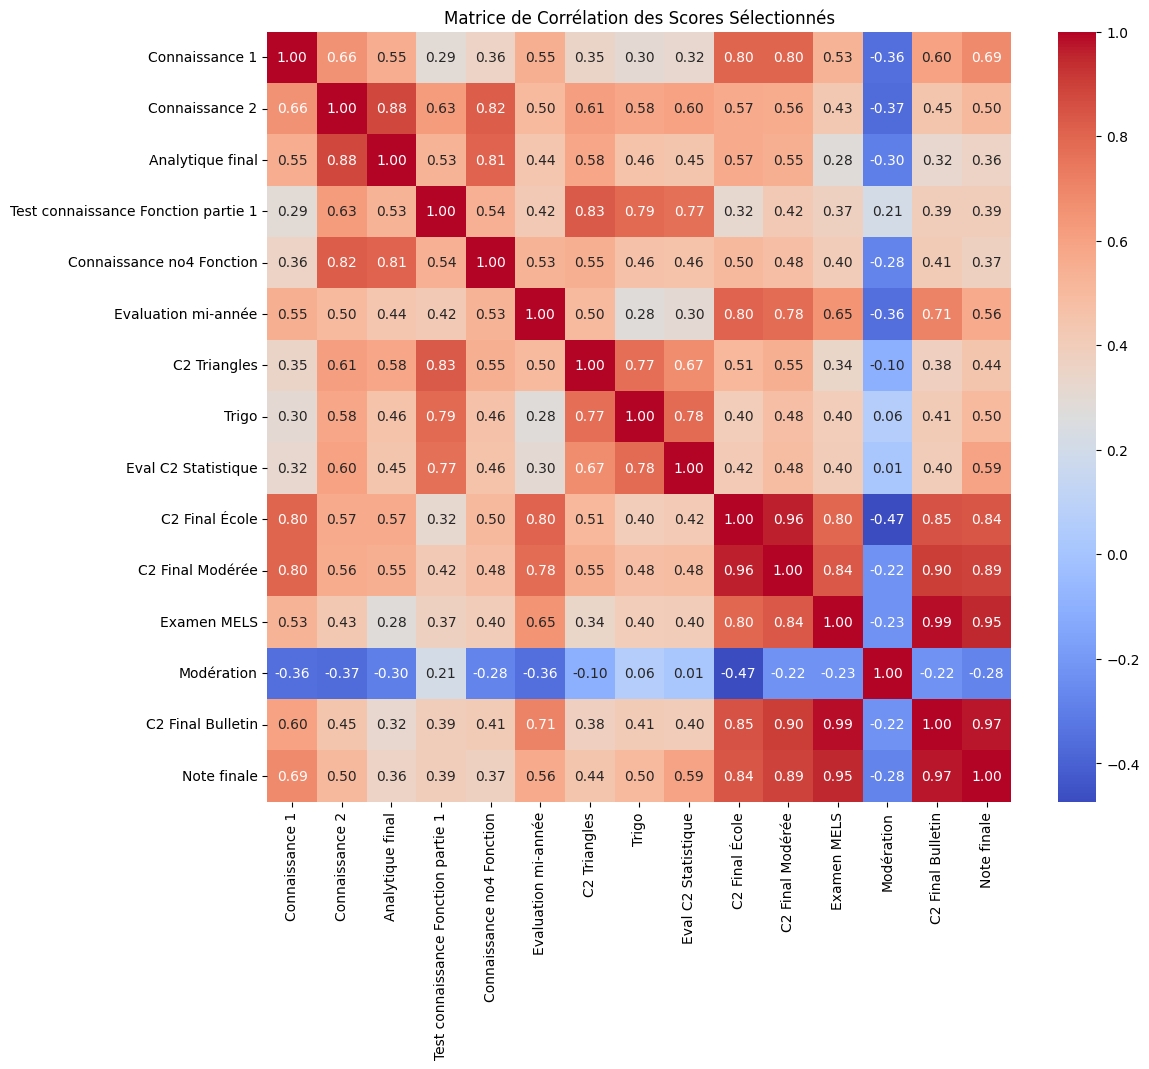

In [15]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de Corrélation des Scores Sélectionnés') # Translated title
plt.show()

In [16]:
from scipy.stats import pearsonr
import pandas as pd

# Get column names from the correlation matrix
columns = correlation_matrix.columns

# Create an empty DataFrame to store p-values
p_values_matrix = pd.DataFrame(index=columns, columns=columns)

# Calculate p-values for each pair of columns
for col1 in columns:
    for col2 in columns:
        # Ensure both columns are in the original df_selected_columns and drop NaNs for the test
        temp_df = df_selected_columns[[col1, col2]].dropna()
        if len(temp_df) > 2: # Need at least 2 data points for correlation
            corr, p_value = pearsonr(temp_df[col1], temp_df[col2])
            # Ensure p_value is a scalar before assigning to the DataFrame
            p_values_matrix.loc[col1, col2] = p_value if isinstance(p_value, (int, float)) else None
        else:
            p_values_matrix.loc[col1, col2] = None # Not enough data

# Filter the p-value matrix to show only values less than 0.2
p_values_matrix_filtered = p_values_matrix.mask(p_values_matrix >= 0.2)

display(p_values_matrix_filtered)

,Connaissance 1,Connaissance 2,Analytique final,Test connaissance Fonction partie 1,Connaissance no4 Fonction,Evaluation mi-année,C2 Triangles,Trigo,Eval C2 Statistique,C2 Final École,C2 Final Modérée,Examen MELS,Modération,C2 Final Bulletin,Note finale
Connaissance 1,None,0.0,0.0,0.010737,0.001613,0.0,0.002093,0.007119,0.004334,0.0,0.0,0.000001,0.001242,0.0,0.0
Connaissance 2,0.0,None,0.0,0.0,0.0,0.000005,0.0,0.0,0.0,0.0,0.0,0.000163,0.000985,0.000075,0.000004
Analytique final,0.0,0.0,None,0.000001,0.0,0.00008,0.0,0.000032,0.000048,0.0,0.0,0.017648,0.008345,0.005242,0.001294
Test connaissance Fonction partie 1,0.010737,0.0,0.000001,None,0.000001,0.000136,0.0,0.0,0.0,0.005291,0.000149,0.000996,0.069552,0.000527,0.000495
Connaissance no4 Fonction,0.001613,0.0,0.0,0.000001,None,0.000001,0.0,0.000024,0.000034,0.000004,0.000014,0.00048,0.015069,0.000414,0.000942
Evaluation mi-année,0.0,0.000005,0.00008,0.000136,0.000001,None,0.000003,0.01334,0.006319,0.0,0.0,0.0,0.001308,0.0,0.0
C2 Triangles,0.002093,0.0,0.0,0.0,0.0,0.000003,None,0.0,0.0,0.000002,0.0,0.002559,NaN,0.000674,0.000043
Trigo,0.007119,0.0,0.000032,0.0,0.000024,0.01334,0.0,None,0.0,0.000271,0.000008,0.000378,NaN,0.000233,0.000003
Eval C2 Statistique,0.004334,0.0,0.000048,0.0,0.000034,0.006319,0.0,0.0,None,0.000135,0.000006,0.000315,NaN,0.000325,0.0
C2 Final École,0.0,0.0,0.0,0.005291,0.000004,0.0,0.000002,0.000271,0.000135,None,0.0,0.0,0.000007,0.0,0.0


In [17]:
# Select the relevant columns and handle non-numeric values
df_comparison = df[['Examen MELS', 'C2 Final École']].copy()
df_comparison['Examen MELS'] = pd.to_numeric(df_comparison['Examen MELS'], errors='coerce')
df_comparison['C2 Final École'] = pd.to_numeric(df_comparison['C2 Final École'], errors='coerce')

# Drop rows with NaN in either column
df_comparison.dropna(inplace=True)

# Count rows where 'Examen MELS' is greater than 'C2 Final École'
count_greater_mels = df_comparison[df_comparison['Examen MELS'] > df_comparison['C2 Final École']].shape[0]

# Calculate the total number of relevant rows
total_rows = df_comparison.shape[0]

# Calculate the percentage
percentage_greater_mels = (count_greater_mels / total_rows) * 100 if total_rows > 0 else 0

print(count_greater_mels)
print(total_rows)

print(f"Percentage of rows with a greater score in Examen MELS than C2 Final École: {percentage_greater_mels:.2f}%")

55
75
Percentage of rows with a greater score in Examen MELS than C2 Final École: 73.33%


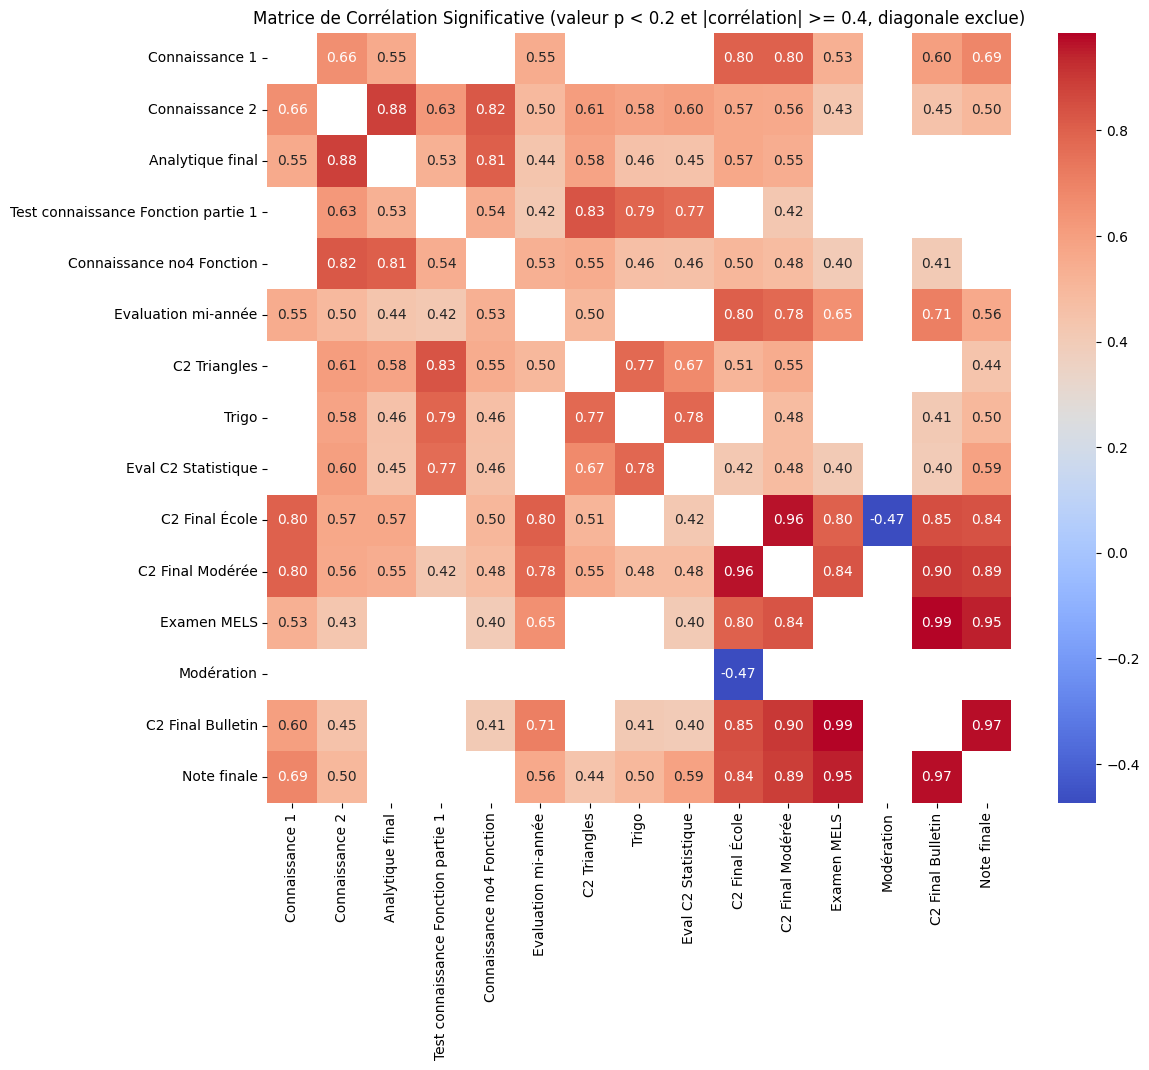

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a mask to hide the diagonal
diagonal_mask = np.eye(correlation_matrix.shape[0], dtype=bool)

# Create a masked correlation matrix
# Mask where p-value is 0.2 or greater OR absolute correlation is less than 0.4 OR it's the diagonal
mask_condition = (p_values_matrix >= 0.2) | (abs(correlation_matrix) < 0.4) | diagonal_mask
masked_correlation_matrix = correlation_matrix.mask(mask_condition)

plt.figure(figsize=(12, 10))
sns.heatmap(masked_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=masked_correlation_matrix.isnull())
plt.title('Matrice de Corrélation Significative (valeur p < 0.2 et |corrélation| >= 0.4, diagonale exclue)') # Translated title
plt.show()

,Examen MELS,C2 Final École,Score Difference
0,96.0,89.0,7.0
1,98.0,79.0,19.0
2,64.0,57.0,7.0
3,80.0,85.0,-5.0
4,98.0,70.0,28.0


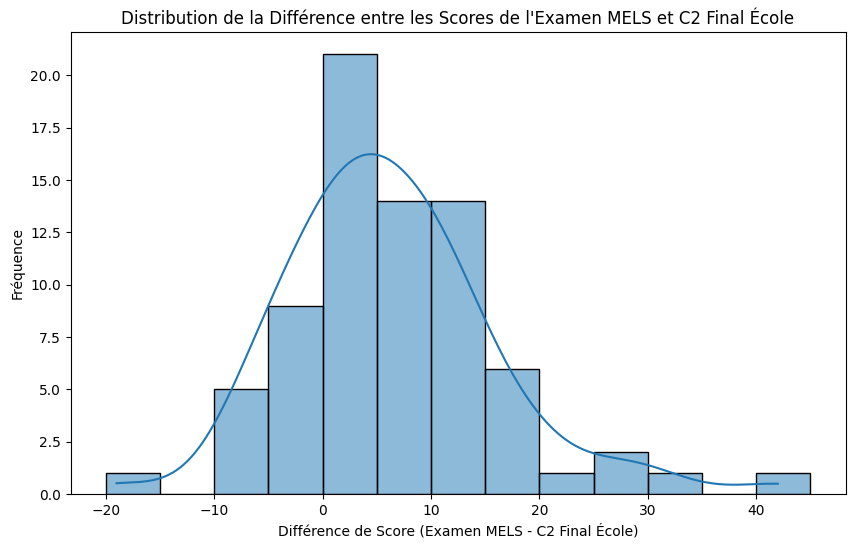

In [19]:
# Calculate the difference between 'Examen MELS' and 'C2 Final École'
df_comparison['Score Difference'] = df_comparison['Examen MELS'] - df_comparison['C2 Final École']

# Display the first few rows with the new column
display(df_comparison.head())

# Plot the distribution of the score difference
plt.figure(figsize=(10, 6))
min_diff = np.floor(df_comparison['Score Difference'].min() / 5) * 5
max_diff = np.ceil(df_comparison['Score Difference'].max() / 5) * 5
sns.histplot(data=df_comparison, x='Score Difference', kde=True, bins=np.arange(min_diff, max_diff + 5, 5))
plt.title('Distribution de la Différence entre les Scores de l\'Examen MELS et C2 Final École') # Translated title
plt.xlabel('Différence de Score (Examen MELS - C2 Final École)') # Translated x-label
plt.ylabel('Fréquence') # Translated y-label
plt.show()

In [20]:
mean_difference = df_comparison['Score Difference'].mean()
print(f"The mean difference between Examen MELS and C2 Final École scores is: {mean_difference:.2f}")

The mean difference between Examen MELS and C2 Final École scores is: 6.23


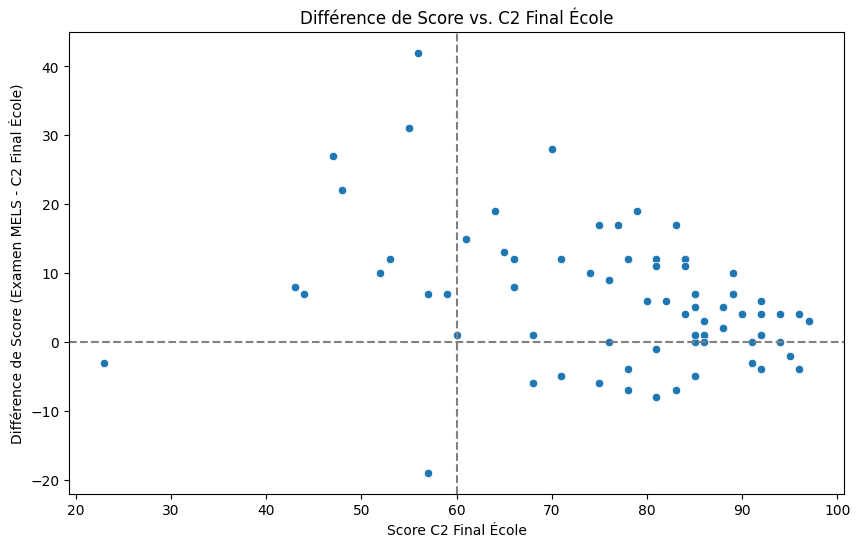

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_comparison, x='C2 Final École', y='Score Difference')

# Add horizontal line at y=0
plt.axhline(0, color='gray', linestyle='--')

# Add vertical line at x=60
plt.axvline(60, color='gray', linestyle='--')

plt.title('Différence de Score vs. C2 Final École') # Translated title
plt.xlabel('Score C2 Final École') # Translated x-label
plt.ylabel('Différence de Score (Examen MELS - C2 Final École)') # Translated y-label
plt.show()

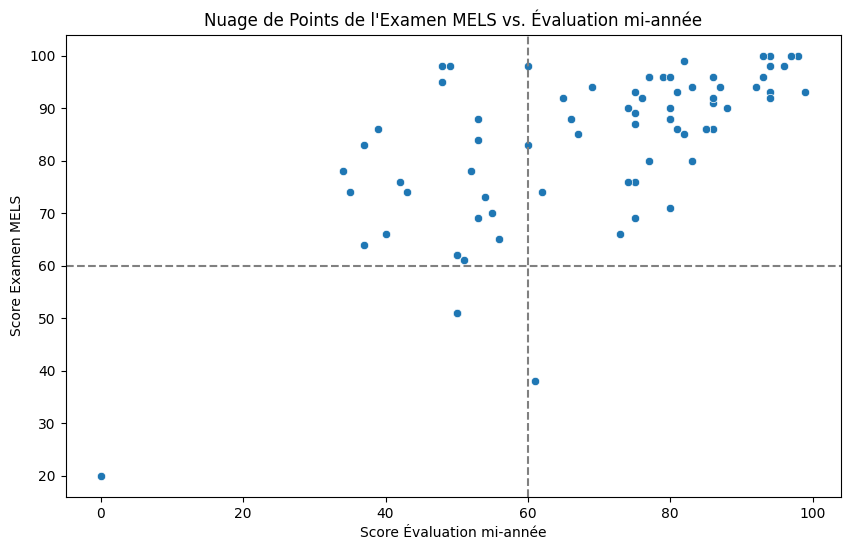

In [22]:
# Select the relevant columns and handle non-numeric values
df_evaluation_mels = df[['Evaluation mi-année', 'Examen MELS']].copy()
df_evaluation_mels['Evaluation mi-année'] = pd.to_numeric(df_evaluation_mels['Evaluation mi-année'], errors='coerce')
df_evaluation_mels['Examen MELS'] = pd.to_numeric(df_evaluation_mels['Examen MELS'], errors='coerce')

# Drop rows with NaN in either column
df_evaluation_mels.dropna(inplace=True)

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_evaluation_mels, x='Evaluation mi-année', y='Examen MELS')
plt.title('Nuage de Points de l\'Examen MELS vs. Évaluation mi-année') # Translated title
plt.xlabel('Score Évaluation mi-année') # Translated x-label
plt.ylabel('Score Examen MELS') # Translated y-label

# Add horizontal line at y=60
plt.axhline(60, color='gray', linestyle='--')

# Add vertical line at x=60
plt.axvline(60, color='gray', linestyle='--')


plt.show()

In [23]:
# Identify columns to exclude
excluded_columns = ['Groupe', 'C2 Final École', 'C2 Final Modérée', 'Modération', 'C2 Final Bulletin', 'Note finale']

# Create a list of feature column names based on the exclusion criteria
feature_columns = [col for col in df.columns if col not in excluded_columns and 'C1' not in col]

# Create the features DataFrame X
X = df[feature_columns].copy()

# Create the target Series y
y = df['Examen MELS'].copy()


In [24]:
rows_greater_than_95 = df_comparison[df_comparison['Score Difference'] > 95]
display(rows_greater_than_95)

,Examen MELS,C2 Final École,Score Difference


In [25]:
!wget https://github.com/quarto-dev/quarto-cli/releases/download/v1.7.33/quarto-1.7.33-linux-amd64.deb
!sudo dpkg -i quarto-1.7.33-linux-amd64.deb

--2025-08-28 15:55:16--  https://github.com/quarto-dev/quarto-cli/releases/download/v1.7.33/quarto-1.7.33-linux-amd64.deb
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
connected.
HTTP request sent, awaiting response... HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/298579934/4632c6cf-a754-47e7-9f33-589e5229bc09?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-08-28T20%3A30%3A20Z&rscd=attachment%3B+filename%3Dquarto-1.7.33-linux-amd64.deb&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-08-28T19%3A29%3A36Z&ske=2025-08-28T20%3A30%3A20Z&sks=b&skv=2018-11-09&sig=H3MEW0bTsE4vV1Oxnaqdy2Y9QdAGtY2LS3LiJK7D1Ug%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6

In [ ]:
!quarto render "/content/drive/MyDrive/Colab Notebooks/AnalyseModerationSec4.ipynb" \
  --to html \
  --embed-resources \
  --include-in-header <(echo '<script src="https://cdn.plot.ly/plotly-2.32.0.min.js"></script>') > /dev/null 2>&1


In [ ]:
!quarto render "AnalyseModerationSec4.ipynb" \
  --to html \
  --embed-resources \
  --include-in-header <(echo '<script src="https://cdn.plot.ly/plotly-2.32.0.min.js"></script>') > /dev/null 2>&1
! firefox "AnalyseModerationSec4.html"



In [ ]:
# Install IPython if not already installed
!pip install IPython